In [1]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pubplots as pp
import acr
plt.rcdefaults()
plt.style.use('default')
style_path = "/Users/driessen2@ad.wisc.edu/kdriessen/acr_dev/acr/src/acr/plot_styles/acrvec_labels.mplstyle"

In [98]:
#--------------------------------- Import Publication Functions ---------------------------------#
pub_utils = acr.utils.import_publication_functions('/Users/driessen2@ad.wisc.edu/kdriessen/gh_master/PUBLICATION__ACR/pub_utils.py', 'pub_utils')
from pub_utils import *
data_agg = acr.utils.import_publication_functions('/Users/driessen2@ad.wisc.edu/kdriessen/gh_master/PUBLICATION__ACR/data_agg.py', 'data_agg')
from data_agg import *

In [2]:
import numpy as np

In [3]:
from acr.utils import PAPER_FIGURE_ROOT
nbroot = os.path.join(PAPER_FIGURE_ROOT, 'response_to_review', 'behavior_during_stim')
if not os.path.exists(nbroot):
    os.mkdir(nbroot)

In [45]:
dfs = []
for p in os.listdir('/Volumes/neuropixel_archive/Data/acr_archive/stimulation_boris_files'):
    subject = p.split('.')[0]
    df = pl.read_csv(os.path.join('/Volumes/neuropixel_archive/Data/acr_archive/stimulation_boris_files', p))
    df = df.with_columns(pl.lit(subject).alias('subject'))
    df = df.drop(['FPS', 'Time offset (s)'])
    dfs.append(df)

In [46]:
fdf = pl.concat(dfs)

In [ ]:
fdf = fdf.filter(pl.col('Behavior type')=='POINT')
total_counts = fdf.group_by('subject').agg(pl.count())
bc = fdf.group_by('subject', 'Behavior').agg(pl.count())
bc = bc.join(total_counts, on='subject', how='left').with_columns((pl.col('count') / pl.col('count_right')).alias('proportion'))
bc = bc.sort(['subject', 'Behavior'])

In [53]:
acr_subs = ['ACR_23', 'ACR_20', 'ACR_31']
som_subs = ['ACR_30', 'ACR_35', 'ACR_44']

In [77]:
acr_left = bc.filter(pl.col('subject').is_in(acr_subs)).filter(pl.col('Behavior')=='left_turn')['proportion'].to_numpy()
acr_right = bc.filter(pl.col('subject').is_in(acr_subs)).filter(pl.col('Behavior')=='right_turn')['proportion'].to_numpy()

In [78]:
som_left = bc.filter(pl.col('subject').is_in(som_subs)).filter(pl.col('Behavior')=='left_turn')['proportion'].to_numpy()
som_right = bc.filter(pl.col('subject').is_in(som_subs)).filter(pl.col('Behavior')=='right_turn')['proportion'].to_numpy()

In [79]:
left_fracs = np.array([acr_left, som_left]).flatten()
right_fracs = np.array([acr_right, som_right]).flatten()

In [57]:
from acr.utils import ACR_BLUE, SOM_BLUE

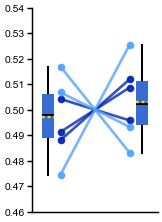

In [100]:
fig_name = "turning_behavior_during_stim"
fig_path = os.path.join(nbroot, f"{fig_name}.svg")
with pp.destination('figma', style=style_path):
    f, ax = plt.subplots(1, 1, figsize=pp.scale(1.2, 1.6))
    ax, box = acr.plots.add_boxplot(
        ax,
        left_fracs,
        positions=[0.35],
        widths=0.04,
        color='#215dcc',
        means=True,
        mean_color="gold",
        mean_linewidth=3.5,
        mean_linestyle="--",
        mean_dashes=(1.2, 1.2),
        alpha=0.9,
    )
    ax, box = acr.plots.add_boxplot(
        ax,
        right_fracs,
        positions=[0.65],
        widths=0.04,
        color='#215dcc',
        means=True,
        mean_color="gold",
        mean_linewidth=3.5,
        mean_linestyle="--",
        mean_dashes=(1.2, 1.2),
        alpha=0.9,
    )
    ax = acr.plots.add_data_points(
        ax, som_left, x_pos=0.39, color=SOM_BLUE, alpha=0.9, s=70, zorder=203
    )
    ax = acr.plots.add_data_points(
        ax, acr_left, x_pos=0.39, color=ACR_BLUE, alpha=0.9, s=70, zorder=203
    )
    ax = acr.plots.add_data_points(
        ax, som_right, x_pos=0.61, color=SOM_BLUE, alpha=0.9, s=70, zorder=203
    )
    ax = acr.plots.add_data_points(
        ax, acr_right, x_pos=0.61, color=ACR_BLUE, alpha=0.9, s=70, zorder=203
    )
    for c, e in zip(som_left, som_right):
        ax.plot([0.39, 0.61], [c, e], color=SOM_BLUE, alpha=0.8, linewidth=4)
    for c, e in zip(acr_left, acr_right):
        ax.plot([0.39, 0.61], [c, e], color=ACR_BLUE, alpha=0.8, linewidth=4)
    
    ax.set_xlim(0.30, 0.70)
    ax.set_xticklabels([None, None])
    #ax.axhline(0.5, color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax.set_ylim(0.46, 0.54)
    f.savefig(fig_path, bbox_inches='tight', transparent=True)

    plt.show()


In [91]:
diffs = right_fracs - left_fracs

In [92]:
pg.wilcoxon(left_fracs, right_fracs)

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,8.0,two-sided,0.6875,-0.238095,0.361111


In [96]:
import pandas as pd

In [99]:
nnxr = right_fracs
nnxo = left_fracs

#stats = pg.ttest(nnxr, nnxo, paired=True)
stats = pg.wilcoxon(nnxr-nnxo)
#hg = pg.compute_effsize(nnxr, nnxo, paired=True, eftype='hedges')
#print(f'hedges g: {hg}')

#r = acr.stats.calculate_wilx_r(stats['W-val'][0], len(nnxr))
# ==== Write Stats Results ====
acr.stats.write_stats_result(
    fig_name, 
    'wilcoxon',
    test_statistic=stats['W-val'][0],
    p_value=stats['p-val'][0],
    effect_size_method='RBC',
    effect_size=stats['RBC'][0],
    review=True,
)

## ===== Write Source Data =====
source_data = pd.DataFrame({'right_turn_fractions': nnxr, 'left_turn_fractions': nnxo, 'subject': np.arange(len(nnxr))})
write_source_data(source_data, fig_name)
stats

/tmp/ipykernel_2673067/2580214026.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_statistic=stats['W-val'][0],
/tmp/ipykernel_2673067/2580214026.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value=stats['p-val'][0],
/tmp/ipykernel_2673067/2580214026.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  effect_size=stats['RBC'][0],
/Users/driessen2@ad.wisc.edu/kdriessen/acr_dev/acr/src/acr/stats.py:124: FutureWarnin

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,8.0,two-sided,0.6875,0.238095,NaN


In [74]:
acr_left = bc.filter(pl.col('subject').is_in(acr_subs)).filter(pl.col('Behavior')=='left_turn')['count'].to_numpy()
acr_right = bc.filter(pl.col('subject').is_in(acr_subs)).filter(pl.col('Behavior')=='right_turn')['count'].to_numpy()
som_left = bc.filter(pl.col('subject').is_in(som_subs)).filter(pl.col('Behavior')=='left_turn')['count'].to_numpy()
som_right = bc.filter(pl.col('subject').is_in(som_subs)).filter(pl.col('Behavior')=='right_turn')['count'].to_numpy()
left_fracs = np.array([acr_left, som_left]).flatten()
right_fracs = np.array([acr_right, som_right]).flatten()

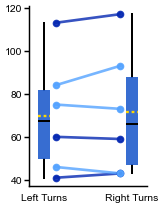

In [61]:
fig_name = "turning_behavior_during_stim_COUNTS"
fig_path = os.path.join(nbroot, f"{fig_name}.svg")
with pp.destination('figma', style=style_path):
    f, ax = plt.subplots(1, 1, figsize=pp.scale(1.2, 1.5))
    ax, box = acr.plots.add_boxplot(
        ax,
        left_fracs,
        positions=[0.35],
        widths=0.04,
        color='#215dcc',
        means=True,
        mean_color="gold",
        mean_linewidth=3.5,
        mean_linestyle="--",
        mean_dashes=(1.2, 1.2),
        alpha=0.9,
    )
    ax, box = acr.plots.add_boxplot(
        ax,
        right_fracs,
        positions=[0.65],
        widths=0.04,
        color='#215dcc',
        means=True,
        mean_color="gold",
        mean_linewidth=3.5,
        mean_linestyle="--",
        mean_dashes=(1.2, 1.2),
        alpha=0.9,
    )
    ax = acr.plots.add_data_points(
        ax, som_left, x_pos=0.39, color=SOM_BLUE, alpha=0.9, s=70, zorder=203
    )
    ax = acr.plots.add_data_points(
        ax, acr_left, x_pos=0.39, color=ACR_BLUE, alpha=0.9, s=70, zorder=203
    )
    ax = acr.plots.add_data_points(
        ax, som_right, x_pos=0.61, color=SOM_BLUE, alpha=0.9, s=70, zorder=203
    )
    ax = acr.plots.add_data_points(
        ax, acr_right, x_pos=0.61, color=ACR_BLUE, alpha=0.9, s=70, zorder=203
    )
    for c, e in zip(som_left, som_right):
        ax.plot([0.39, 0.61], [c, e], color=SOM_BLUE, alpha=0.8, linewidth=4)
    for c, e in zip(acr_left, acr_right):
        ax.plot([0.39, 0.61], [c, e], color=ACR_BLUE, alpha=0.8, linewidth=4)
    
    ax.set_xlim(0.30, 0.70)
    ax.set_xticklabels([None, None])
    #ax.set_ylim(0.45, 0.55)
    ax.set_xticklabels(['Left Turns', 'Right Turns'])
    f.savefig(fig_path, bbox_inches='tight', transparent=True)
    

    plt.show()
